In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import time
from darts import TimeSeries
from darts.models import NBEATSModel
from pytorch_lightning.callbacks import ModelCheckpoint



d:\GAME\Anaconda\envs\machinelearning_joseportilla\lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
df_begin=pd.read_csv('D:\\KULIAH\\teep\AI\\dataset\\52 cells\\CellReports.csv')
df_begin

,timestamp,Viavi.Cell.Name,DRB.UEThpDl,DRB.UEThpUl,RRU.PrbUsedDl,RRU.PrbUsedUl,RRU.PrbAvailDl,RRU.PrbAvailUl,RRU.PrbTotUl,RRU.PrbTotDl,RRU.MaxLayerDlMimo,CARR.AverageLayersDl,RRC.ConnMean,RRC.ConnMax,QosFlow.TotPdcpPduVolumeUl,QosFlow.TotPdcpPduVolumeDl,PEE.AvgPower,PEE.Energy
0,1672502400,S1/B2/C1,0.278192,0.278192,81.459016,81.459016,100,100,81.459016,81.459016,0.0,0.0,1.786885,2.311475,277.868853,277.868853,281.947679,0.004195
1,1672502400,S7/B2/C1,0.146310,0.146310,50.000000,50.000000,100,100,50.000000,50.000000,0.0,0.0,0.516667,1.316667,146.050000,146.050000,180.817352,0.002292
2,1672502400,S8/B2/C1,0.220303,0.220303,64.300000,64.300000,100,100,64.300000,64.300000,0.0,0.0,1.450000,3.966667,220.083333,220.083333,230.893458,0.004631
3,1672502400,S9/B2/C1,0.186428,0.186428,80.900000,80.900000,100,100,80.900000,80.900000,0.0,0.0,1.916667,6.900000,186.083333,186.083333,279.584476,0.005326
4,1672502400,S1/B13/C1,0.000000,0.000000,0.000000,0.000000,75,75,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,18.250000,0.000360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524206,1673107140,S3/N77/C2,0.000000,0.000000,0.000000,0.000000,273,273,0.000000,0.000000,0.0,0.0,0.000000,4.000000,0.000000,0.000000,21.000000,11.000064
524207,1673107140,S3/N77/C3,0.000000,0.000000,0.000000,0.000000,273,273,0.000000,0.000000,0.0,0.0,0.000000,2.000000,0.000000,0.000000,21.000000,7.609575
524208,1673107140,S4/N77/C1,0.000000,0.000000,0.000000,0.000000,273,273,0.000000,0.000000,0.0,0.0,0.000000,3.000000,0.000000,0.000000,21.000000,7.789410
524209,1673107140,S4/N77/C2,0.000000,0.000000,0.000000,0.000000,273,273,0.000000,0.000000,0.0,0.0,0.000000,5.000000,0.000000,0.000000,21.000000,18.617635


In [3]:
df_1=df_begin.copy()
df_1.drop(columns=['RRU.PrbAvailDl', 'RRU.PrbAvailUl','RRU.PrbTotUl','RRU.PrbTotDl','RRC.ConnMax'], inplace=True)
convert_time=pd.to_datetime(df_1['timestamp'], unit='s',origin='unix')
df_1.insert(df_1.columns.get_loc('timestamp') + 1, 'datetime_column', convert_time)
df_1.set_index('datetime_column', inplace=True)
df_1.drop(columns=['timestamp'], inplace=True)

In [4]:
# Filter for specific columns and their correlations
corr_matrix = df_1.corr(numeric_only=True)[['RRU.PrbUsedDl', 'RRU.PrbUsedUl']]
display(corr_matrix)
filtered_corr = corr_matrix[['RRU.PrbUsedDl', 'RRU.PrbUsedUl']]

# Find columns where correlation with 'RRU.PrbUsedDl' or 'RRU.PrbUsedUl' is greater than 0.5
columns_with_high_corr = filtered_corr.index[(filtered_corr['RRU.PrbUsedDl'] > 0.5) & (filtered_corr['RRU.PrbUsedUl'] > 0.5)].tolist()

print("higher correlation > 0.5:\n", columns_with_high_corr)

,RRU.PrbUsedDl,RRU.PrbUsedUl
DRB.UEThpDl,0.609351,0.655949
DRB.UEThpUl,0.551258,0.604384
RRU.PrbUsedDl,1.000000,0.976418
RRU.PrbUsedUl,0.976418,1.000000
RRU.MaxLayerDlMimo,0.564125,0.475535
CARR.AverageLayersDl,0.564125,0.475535
RRC.ConnMean,0.546933,0.582082
QosFlow.TotPdcpPduVolumeUl,0.551093,0.604202
QosFlow.TotPdcpPduVolumeDl,0.609268,0.655836
PEE.AvgPower,0.781520,0.832680


higher correlation > 0.5:
 ['DRB.UEThpDl', 'DRB.UEThpUl', 'RRU.PrbUsedDl', 'RRU.PrbUsedUl', 'RRC.ConnMean', 'QosFlow.TotPdcpPduVolumeUl', 'QosFlow.TotPdcpPduVolumeDl', 'PEE.AvgPower']


In [5]:
seleted_columns = columns_with_high_corr
df_1= df_1[seleted_columns].copy()
df_1

,DRB.UEThpDl,DRB.UEThpUl,RRU.PrbUsedDl,RRU.PrbUsedUl,RRC.ConnMean,QosFlow.TotPdcpPduVolumeUl,QosFlow.TotPdcpPduVolumeDl,PEE.AvgPower
datetime_column,,,,,,,,
2022-12-31 16:00:00,0.278192,0.278192,81.459016,81.459016,1.786885,277.868853,277.868853,281.947679
2022-12-31 16:00:00,0.146310,0.146310,50.000000,50.000000,0.516667,146.050000,146.050000,180.817352
2022-12-31 16:00:00,0.220303,0.220303,64.300000,64.300000,1.450000,220.083333,220.083333,230.893458
2022-12-31 16:00:00,0.186428,0.186428,80.900000,80.900000,1.916667,186.083333,186.083333,279.584476
2022-12-31 16:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000
...,...,...,...,...,...,...,...,...
2023-01-07 15:59:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
2023-01-07 15:59:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
2023-01-07 15:59:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000


In [6]:
try:
    df_2= df_1.resample('min').mean().drop(columns=['Viavi.Cell.Name'])
except:
    df_2= df_1.resample('min').mean()
df=df_2.astype(float).copy()
df

,DRB.UEThpDl,DRB.UEThpUl,RRU.PrbUsedDl,RRU.PrbUsedUl,RRC.ConnMean,QosFlow.TotPdcpPduVolumeUl,QosFlow.TotPdcpPduVolumeDl,PEE.AvgPower
datetime_column,,,,,,,,
2022-12-31 16:00:00,0.112853,0.109073,41.647609,40.984468,0.923145,108.877027,112.657593,163.482931
2022-12-31 16:01:00,0.100812,0.096750,42.121474,41.068910,0.923397,96.565170,100.627194,153.417886
2022-12-31 16:02:00,0.106379,0.102369,41.851282,40.958333,0.921795,102.151550,106.161736,158.808699
2022-12-31 16:03:00,0.100694,0.098010,42.577885,41.491026,0.922115,97.808665,100.492253,157.386986
2022-12-31 16:04:00,0.109902,0.107143,43.626603,42.665705,0.921795,106.939023,109.697512,167.089184
...,...,...,...,...,...,...,...,...
2023-01-07 15:55:00,0.110139,0.107350,42.102244,41.227244,0.922115,107.129670,109.918532,164.456731
2023-01-07 15:56:00,0.099864,0.098178,40.426282,39.726282,0.923077,97.959150,99.644908,159.064446
2023-01-07 15:57:00,0.114258,0.110941,40.190705,40.190705,0.923077,110.729551,114.046510,161.020629


In [7]:
n = len(df)
train_df =df[0:int(n*0.9048)]
val_df = df[int(n*0.9048):]
test_df = df[int(n*0.9048):]

num_features = df.shape[1]

In [8]:
import numpy as np
import pandas as pd

def standardize_data(data, isoutput=True, column_output=['RRU.PrbUsedDl', 'RRU.PrbUsedUl'], train_df=train_df):
    if isoutput:
        mean = train_df[column_output].mean().values
        std = train_df[column_output].std().values
    else:
        mean = train_df.mean().values
        std = train_df.std().values

    # Reshape for broadcasting with 2D matrix
    mean = mean.reshape(1, -1)
    std = std.reshape(1, -1)

    return (data - mean) / std

def inverse_standardize_data(data, isoutput=True, column_output=['RRU.PrbUsedDl', 'RRU.PrbUsedUl'], train_df=train_df):
    if isoutput:
        mean = train_df[column_output].mean().values
        std = train_df[column_output].std().values
    else:
        mean = train_df.mean().values
        std = train_df.std().values

    # Reshape for broadcasting with 2D matrix
    mean = mean.reshape(1, -1)
    std = std.reshape(1, -1)

    return (data * std) + mean


In [9]:
train_scaled = standardize_data(train_df, isoutput=False)
val_scaled= standardize_data(val_df, isoutput=False)
test_scaled= standardize_data(test_df, isoutput=False)

In [10]:
# Konversi DataFrame ke TimeSeries
train_input_series= TimeSeries.from_dataframe(train_scaled)
train_target_series = TimeSeries.from_dataframe(train_scaled, value_cols=['RRU.PrbUsedDl','RRU.PrbUsedUl'])
# Konversi DataFrame ke TimeSeries
val_input_series= TimeSeries.from_dataframe(val_scaled)
val_target_series = TimeSeries.from_dataframe(val_scaled, value_cols=['RRU.PrbUsedDl','RRU.PrbUsedUl'])


<AxesSubplot: xlabel='datetime_column'>

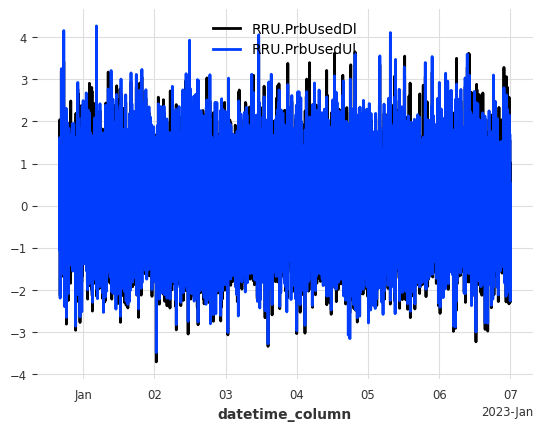

In [11]:
train_input_series[['RRU.PrbUsedDl','RRU.PrbUsedUl']].plot()

In [12]:

torch.set_float32_matmul_precision('medium')

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [13]:
import datetime
import time
from darts import TimeSeries
from darts.models import XGBModel
# Suppress the specific FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Function delayed is deprecated")

# Get the current date and time
now = datetime.datetime.now()

# Format the date and time to a string
timestamp = now.strftime("%Y%m%d_%H%M")
print(timestamp)
nama_file = 'xgboost_%s.pth' % timestamp

# Initialize and configure the XGBoost model
model = XGBModel(
    lags=120,  # Panjang input window
    lags_past_covariates=120,  # Panjang input covariates window
    output_chunk_length=60,  # Panjang prediksi
    random_state=0,
    n_estimators=10,
    device='cuda'  # Enable GPU usage by setting the device to 'cuda'
)

# Start timer for training duration
start_time = time.time()

# Fit the model
model.fit(
    series=train_target_series,
    past_covariates=train_input_series,
    val_series=val_target_series,
    val_past_covariates=val_input_series,
    verbose=True
)

# Print the training duration
print("--- %s seconds ---" % (time.time() - start_time))

# Save the model
model.save(nama_file)  # Use save_model method for saving


20240721_2003


d:\GAME\Anaconda\envs\machinelearning_joseportilla\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


[0]	validation_0-rmse:0.97328
[1]	validation_0-rmse:0.97068
[2]	validation_0-rmse:0.97265
[3]	validation_0-rmse:0.96351
[4]	validation_0-rmse:0.96262
[5]	validation_0-rmse:0.95933
[6]	validation_0-rmse:0.95860
[7]	validation_0-rmse:0.96012
[8]	validation_0-rmse:0.96010
[9]	validation_0-rmse:0.96113
[0]	validation_0-rmse:0.95072
[1]	validation_0-rmse:0.94420
[2]	validation_0-rmse:0.93969
[3]	validation_0-rmse:0.94429
[4]	validation_0-rmse:0.94400
[5]	validation_0-rmse:0.94137
[6]	validation_0-rmse:0.94570
[7]	validation_0-rmse:0.94620
[8]	validation_0-rmse:0.94717
[9]	validation_0-rmse:0.94349
[0]	validation_0-rmse:0.96642
[1]	validation_0-rmse:0.95988
[2]	validation_0-rmse:0.95571
[3]	validation_0-rmse:0.94916
[4]	validation_0-rmse:0.94551
[5]	validation_0-rmse:0.94267
[6]	validation_0-rmse:0.94133
[7]	validation_0-rmse:0.94245
[8]	validation_0-rmse:0.94016
[9]	validation_0-rmse:0.94214
[0]	validation_0-rmse:0.95504
[1]	validation_0-rmse:0.95191
[2]	validation_0-rmse:0.95576
[3]	valida

In [24]:
loaded_model = XGBModel.load(nama_file)
start_time= time.time()
predictions = loaded_model.predict(n=60, series=train_target_series[-120:], past_covariates=train_input_series[-120:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7494254112243652 seconds ---


<AxesSubplot: xlabel='datetime_column'>

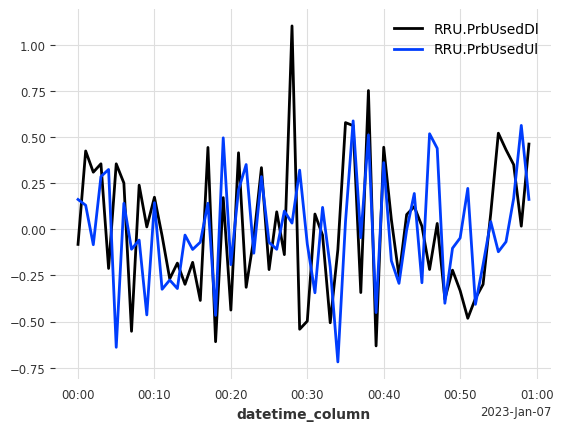

In [25]:
predictions.plot()

In [26]:
values = predictions.values()
time_index = predictions.time_index

# Convert to DataFrame
df_predictions = pd.DataFrame(values, index=time_index, columns=['RRU.PrbUsedDl', 'RRU.PrbUsedUl'])
df_predictions =inverse_standardize_data(df_predictions, isoutput=True, column_output=['RRU.PrbUsedDl', 'RRU.PrbUsedUl'], train_df=train_df)

<AxesSubplot: xlabel='datetime_column'>

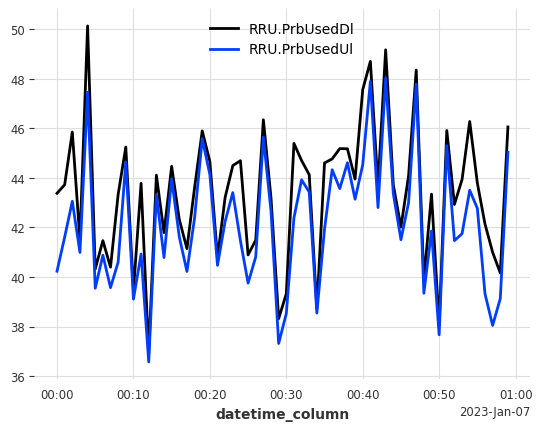

In [27]:
TimeSeries.from_dataframe(df.loc[df_predictions.index][['RRU.PrbUsedDl', 'RRU.PrbUsedUl']]).plot()